
 Imports & Device Setup



In [1]:
import re
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pickle
import os
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


Data Loading and Cleaning

In [2]:

def load_and_clean_text(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read().lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'(\w)(\.)', r'\1 .', text)
    text = re.sub(r'[^a-zA-Z0-9 .]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    return words


Vocabulary Creation

In [3]:

def build_vocab(words):
    vocab = sorted(set(words))
    stoi = {'<PAD>': 0, '<UNK>': 1}
    for idx, w in enumerate(vocab, start=2):
        stoi[w] = idx
    itos = {i: w for w, i in stoi.items()}
    vocab_size = len(stoi)
    return stoi, itos, vocab_size


Dataset Creation

In [4]:
def create_dataset(words, stoi, itos, context_length, show_first_n=20):
    X, Y = [], []
    for i in range(len(words) - context_length):
        context = words[i:i+context_length]
        target = words[i+context_length]
        X.append([stoi.get(w, 1) for w in context])  # 1 = <UNK>
        Y.append(stoi.get(target, 1))

        if i < show_first_n:
            print(f"{' '.join(context)} ---> {target}")

    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)
    print(f"\n Dataset created with shapes: X: {X.shape}, Y: {Y.shape}")
    return X, Y


MLP Next-Word Model

In [5]:

class NextWordMLP(nn.Module):
    def __init__(self, vocab_size, emb_dim, context_length, hidden1, hidden2=None,
                 activation='relu', dropout=0.2):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)

        activation_layer = {
            'relu': nn.ReLU(),
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid(),
            'gelu': nn.GELU(),
            'leakyrelu': nn.LeakyReLU()
        }.get(activation.lower(), nn.ReLU())

        layers = [nn.Flatten(),
                  nn.Linear(context_length * emb_dim, hidden1),
                  activation_layer,
                  nn.Dropout(dropout)]
        if hidden2:
            layers += [nn.Linear(hidden1, hidden2),
                       activation_layer,
                       nn.Dropout(dropout)]
            layers += [nn.Linear(hidden2, vocab_size)]
        else:
            layers += [nn.Linear(hidden1, vocab_size)]
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        x = self.emb(x)
        return self.mlp(x)

    def get_embeddings(self):
        return self.emb.weight.detach().cpu().numpy()

Visualization Utility

In [6]:
def visualize_embeddings(model, itos, emb_dim=64, n_words=200, title="Embeddings"):
    embeddings = model.get_embeddings()
    if emb_dim != 2:
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        emb_2d = tsne.fit_transform(embeddings[2:2+n_words])
    else:
        emb_2d = embeddings[2:2+n_words]
    plt.figure(figsize=(12, 10))
    plt.scatter(emb_2d[:, 0], emb_2d[:, 1], s=12, alpha=0.7)
    for i in range(n_words):
        plt.annotate(itos[i+2], (emb_2d[i, 0], emb_2d[i, 1]), fontsize=7, alpha=0.7)
    plt.title(title)
    plt.show()

Training Loop

In [7]:
def train_model(model, X, Y, epochs=1000, batch_size=4096, lr=0.003, print_every=100):
    optimizer = optim.AdamW(model.parameters(), lr=lr)  # Using AdamW optimizer
    loss_fn = nn.CrossEntropyLoss()                     # Using cross-entropy loss for classification

    losses = []  # To store average loss for each epoch

    for epoch in range(epochs):
        # Shuffle indices to randomize batches each epoch
        perm = torch.randperm(X.size(0))

        total_loss = 0  # Total loss for the epoch

        for i in range(0, X.size(0), batch_size):
            # Get batch indices
            idx = perm[i:i+batch_size]
            xb = X[idx].to(device)  # Batch input on device
            yb = Y[idx].to(device)  # Batch target on device

            optimizer.zero_grad()   # Reset gradients

            out = model(xb)         # Forward pass: get predictions

            loss = loss_fn(out, yb) # Compute cross-entropy loss

            loss.backward()         # Backward pass: compute gradients

            optimizer.step()        # Update model weights

            # Accumulate loss weighted by batch size for averaging later
            total_loss += loss.item() * xb.size(0)

        # Compute average loss for this epoch
        avg_loss = total_loss / X.size(0)
        losses.append(avg_loss)

        # Optionally print progress
        if epoch % print_every == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return losses  # Return list of epoch-wise average losses for plotting/analysis


Text Generation Utility

In [8]:
def generate_text(model, seed_text, length=30, context_length=5, temperature=1.0):
    model.eval()  # Set model to evaluation mode (turns off dropout, etc.)

    # Preprocess seed text: lowercase and split into words
    words_in = seed_text.lower().split()

    # Build initial context:
    # - If the seed text has fewer words than context_length, pad with 0 (<PAD>).
    # - Map words to indices using stoi; use 1 (<UNK>) if word is not found.
    context = (
        [0] * max(0, context_length - len(words_in)) +
        [stoi.get(w, 1) for w in words_in]
    )[-context_length:]

    generated = words_in.copy()  # Start generated sequence with the seed text

    for _ in range(length):
        # Prepare context tensor of shape [1, context_length]
        x = torch.tensor([context], dtype=torch.long).to(device)

        with torch.no_grad():
            logits = model(x).squeeze(0)      # Get raw scores for each vocab word
            logits = logits / temperature      # Adjust randomness

            probs = torch.softmax(logits, dim=-1).cpu()  # Convert to probabilities

        # Sample the next word index from the probability distribution
        next_idx = torch.multinomial(probs, num_samples=1).item()

        # Get the corresponding word (or <UNK> if missing)
        next_word = itos.get(next_idx, "<UNK>")

        # Append generated word to the sequence
        generated.append(next_word)

        # Update context for next prediction by removing the oldest and adding the new word
        context = context[1:] + [next_idx]

    # Return the generated words joined as a string
    return ' '.join(generated)

Saving Utilities

In [9]:
def save_artifacts(model, stoi, itos, emb_dim, context_length,
                   hidden1, hidden2, activation,
                   base_name="nextword_holmes_bundle"):
    """
    Saves:
    - model.state_dict
    - stoi and itos dictionaries
    - config dictionary (architecture hyperparameters)

    into a single .pt file for clean, consistent loading in Streamlit or CLI.
    """
    artifacts = {
        'model_state_dict': model.state_dict(),
        'stoi': stoi,
        'itos': itos,
        'config': {
            'vocab_size': len(stoi) + 1,  # +1 for padding/unknown handling
            'emb_dim': emb_dim,
            'context_length': context_length,
            'hidden1': hidden1,
            'hidden2': hidden2,
            'activation': activation
        }
    }

    save_path = f"{base_name}.pt"
    torch.save(artifacts, save_path)
    print(f"All artifacts saved to {save_path}")


# Sherlock Holmes Dataset

In [10]:
!wget https://www.gutenberg.org/files/1661/1661-0.txt -O holmes.txt

--2025-07-08 07:45:16--  https://www.gutenberg.org/files/1661/1661-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607504 (593K) [text/plain]
Saving to: ‘holmes.txt’

holmes.txt          100%[===================>] 593.27K  1.74MB/s    in 0.3s    

2025-07-08 07:45:17 (1.74 MB/s) - ‘holmes.txt’ saved [607504/607504]



In [11]:
# Load and clean

words = load_and_clean_text('holmes.txt')
print(f"Sample cleaned words: {words[:20]}")


# Build vocab
stoi, itos, vocab_size = build_vocab(words)
print(f"Vocab size: {vocab_size}")
print(f"Sample vocab mappings: {list(stoi.items())[:10]}")


# Create dataset
context_length= 5  # can modify for experiments
X, Y = create_dataset(words, stoi, itos, context_length)
print(f"Dataset created with shape X: {X.shape}, Y: {Y.shape}")
print(f"Sample X[0]: {X[0]}, corresponding words: {[itos[idx.item()] for idx in X[0]]}")
print(f"Sample Y[0]: {Y[0]}, corresponding word: {itos[Y[0].item()]}")


Sample cleaned words: ['the', 'project', 'gutenberg', 'ebook', 'of', 'the', 'adventures', 'of', 'sherlock', 'holmes', 'by', 'arthur', 'conan', 'doyle', 'this', 'ebook', 'is', 'for', 'the', 'use']
Vocab size: 8170
Sample vocab mappings: [('<PAD>', 0), ('<UNK>', 1), ('.', 2), ('.1', 3), ('.2', 4), ('.3', 5), ('.4', 6), ('.5', 7), ('.6', 8), ('.7', 9)]
the project gutenberg ebook of ---> the
project gutenberg ebook of the ---> adventures
gutenberg ebook of the adventures ---> of
ebook of the adventures of ---> sherlock
of the adventures of sherlock ---> holmes
the adventures of sherlock holmes ---> by
adventures of sherlock holmes by ---> arthur
of sherlock holmes by arthur ---> conan
sherlock holmes by arthur conan ---> doyle
holmes by arthur conan doyle ---> this
by arthur conan doyle this ---> ebook
arthur conan doyle this ebook ---> is
conan doyle this ebook is ---> for
doyle this ebook is for ---> the
this ebook is for the ---> use
ebook is for the use ---> of
is for the use of ---> 

In [12]:

# Hyperparameters
emb_dim = 64
hidden1 = 1024
hidden2 = 512
activation = 'relu'
dropout = 0.2

# Instantiate
model = NextWordMLP(vocab_size, emb_dim, context_length, hidden1, hidden2, activation, dropout).to(device)

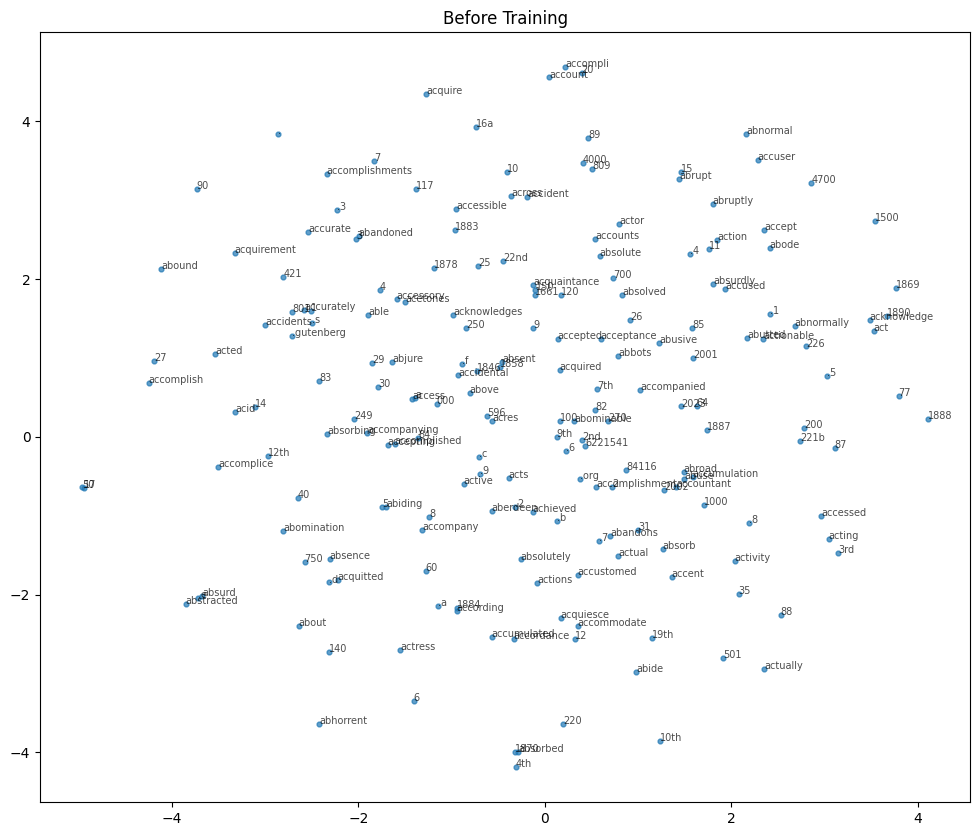

In [13]:

# Visualize Before
visualize_embeddings(model, itos, emb_dim, n_words=200, title="Before Training")


In [14]:
# Train
losses = train_model(model, X, Y, epochs=2000, batch_size=4096, lr=0.002)

Epoch 1/2000, Loss: 6.6946
Epoch 101/2000, Loss: 0.6543
Epoch 201/2000, Loss: 0.3784
Epoch 301/2000, Loss: 0.2890
Epoch 401/2000, Loss: 0.2359
Epoch 501/2000, Loss: 0.2053
Epoch 601/2000, Loss: 0.1831
Epoch 701/2000, Loss: 0.1657
Epoch 801/2000, Loss: 0.1528
Epoch 901/2000, Loss: 0.1407
Epoch 1001/2000, Loss: 0.1359
Epoch 1101/2000, Loss: 0.1291
Epoch 1201/2000, Loss: 0.1222
Epoch 1301/2000, Loss: 0.1184
Epoch 1401/2000, Loss: 0.1164
Epoch 1501/2000, Loss: 0.1100
Epoch 1601/2000, Loss: 0.1092
Epoch 1701/2000, Loss: 0.1040
Epoch 1801/2000, Loss: 0.1015
Epoch 1901/2000, Loss: 0.0988
Epoch 2000/2000, Loss: 0.0984


In [16]:
# Save
save_artifacts(
    model=model,
    stoi=stoi,
    itos=itos,
    emb_dim=emb_dim,
    context_length=context_length,
    hidden1=hidden1,
    hidden2=hidden2,
    activation=activation,
    base_name="holmes_64_relu_mlp"
)

All artifacts saved to holmes_64_relu_mlp.pt


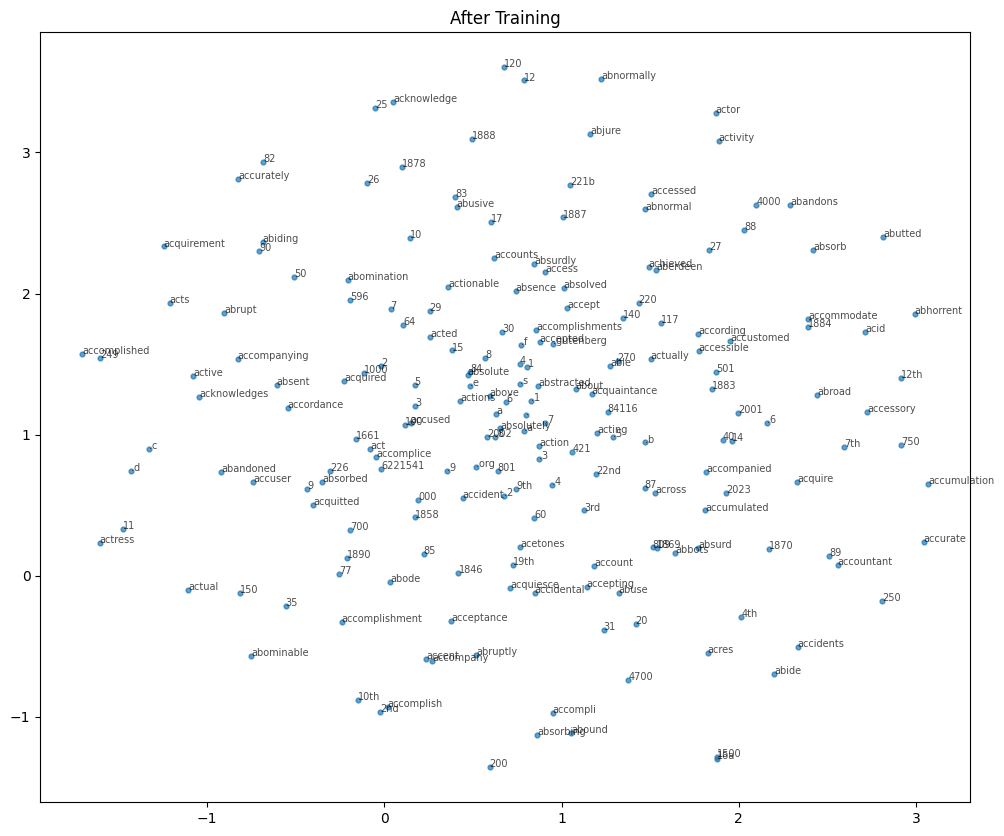

In [17]:

# Visualize After
visualize_embeddings(model, itos, emb_dim, n_words=200, title="After Training")


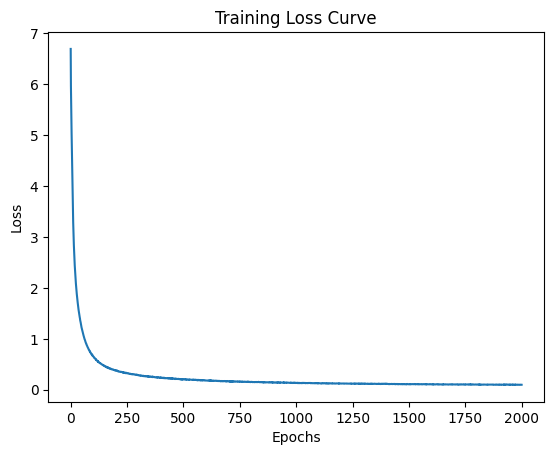

In [18]:

# Plot Loss
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

In [20]:

# Test Generation
seed = "the adventure of"
generated = generate_text(model, seed, length=200, context_length=context_length)
print("\n Sample Generated Text:\n", generated)



 Sample Generated Text:
 the adventure of hot upon the other side . without a word he grasped my arm and hurried me into a carriage the door of which was standing open . he drew up the windows on either side tapped on the wood work and away we went as fast as the horse could go . one horse interjected holmes . yes only one . did you observe the colour yes i saw it by the side lights when i was stepping into the carriage . it was a chestnut . tired looking or fresh oh fresh and glossy . thank you . i am sorry to give you such a two edged thing but i can t say what turn things are going to take . kindly sign the paper where mr . fordham shows you . i signed the paper as directed and the lawyer took it away with him . the singular incident made as you may think the deepest impression upon me and i could not think that his explanation of the fuller s earth was sufficient to explain the necessity for my coming at midnight and his extreme anxiety lest i should tell anyone of my errand . how

# Wikipedia dataset (enwik8)

In [ ]:
# Download enwik8 (100MB Wikipedia Hutter Prize dataset)
!wget http://mattmahoney.net/dc/enwik8.zip -O enwik8.zip

# Unzip
!unzip -o enwik8.zip

# Check file size
!ls -lh enwik8

# Display first 500 characters to inspect
with open('enwik8', 'r', encoding='utf-8', errors='ignore') as f:
    print(f.read(500))


In [ ]:
# Load and clean

words = load_and_clean_text('enwik8')
print(f"Sample cleaned words: {words[:20]}")


# Build vocab
stoi, itos, vocab_size = build_vocab(words)
print(f"Vocab size: {vocab_size}")
print(f"Sample vocab mappings: {list(stoi.items())[:10]}")


# Create dataset
context_length= 5  # can modify for experiments
X, Y = create_dataset(words, stoi, itos, context_length)
print(f"Dataset created with shape X: {X.shape}, Y: {Y.shape}")
print(f"Sample X[0]: {X[0]}, corresponding words: {[itos[idx.item()] for idx in X[0]]}")
print(f"Sample Y[0]: {Y[0]}, corresponding word: {itos[Y[0].item()]}")

# Shakespeare dataset

In [ ]:
# Download Shakespeare dataset
!wget https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt -O shakespeare.txt

# Check file size
!ls -lh shakespeare.txt

# Display first 500 characters to inspect
with open('shakespeare.txt', 'r', encoding='utf-8') as f:
    print(f.read(500))


In [ ]:
# Load and clean

words = load_and_clean_text('shakespeare.txt')
print(f"Sample cleaned words: {words[:20]}")


# Build vocab
stoi, itos, vocab_size = build_vocab(words)
print(f"Vocab size: {vocab_size}")
print(f"Sample vocab mappings: {list(stoi.items())[:10]}")


# Create dataset
context_length= 5  # can modify for experiments
X, Y = create_dataset(words, stoi, itos, context_length)
print(f"Dataset created with shape X: {X.shape}, Y: {Y.shape}")
print(f"Sample X[0]: {X[0]}, corresponding words: {[itos[idx.item()] for idx in X[0]]}")
print(f"Sample Y[0]: {Y[0]}, corresponding word: {itos[Y[0].item()]}")

# Tolstoy's War and Peace

In [ ]:
# Download War and Peace dataset
!wget https://cs.stanford.edu/people/karpathy/char-rnn/warpeace_input.txt -O warpeace.txt

# Check file size
!ls -lh warpeace.txt

# Display first 500 characters to inspect
with open('warpeace.txt', 'r', encoding='utf-8') as f:
    print(f.read(500))


In [ ]:
# Load and clean

words = load_and_clean_text('holmes.txt')
print(f"Sample cleaned words: {words[:20]}")


# Build vocab
stoi, itos, vocab_size = build_vocab(words)
print(f"Vocab size: {vocab_size}")
print(f"Sample vocab mappings: {list(stoi.items())[:10]}")


# Create dataset
context_length= 5  # can modify for experiments
X, Y = create_dataset(words, stoi, itos, context_length)
print(f"Dataset created with shape X: {X.shape}, Y: {Y.shape}")
print(f"Sample X[0]: {X[0]}, corresponding words: {[itos[idx.item()] for idx in X[0]]}")
print(f"Sample Y[0]: {Y[0]}, corresponding word: {itos[Y[0].item()]}")